<a href="https://colab.research.google.com/github/AshishGusain17/ML_Projs/blob/master/JantaHack_CustomerSegmentation/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.sparse import lil_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import copy
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier

 

In [2]:
df_train = pd.read_csv('/content/train.csv')
df_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [12]:
df_train = pd.read_csv('/content/train.csv')
df_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [13]:
df_train = df_train.dropna()
df_train = df_train.reset_index(drop=True)


In [14]:
# nominal = gender , ever_married , graduated , profession
# ordinal = spending score
# var_1 no idea

df_train["Work_Experience"] = df_train["Work_Experience"].astype("int")
df_train["Family_Size"] = df_train["Family_Size"].astype("int")
df_train

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1,Low,4,Cat_4,D
1,466315,Female,Yes,67,Yes,Engineer,1,Low,1,Cat_6,B
2,461735,Male,Yes,67,Yes,Lawyer,0,High,2,Cat_6,B
3,461319,Male,Yes,56,No,Artist,0,Average,2,Cat_6,C
4,460156,Male,No,32,Yes,Healthcare,1,Low,3,Cat_6,C
...,...,...,...,...,...,...,...,...,...,...,...
6660,463002,Male,Yes,41,Yes,Artist,0,High,5,Cat_6,B
6661,464685,Male,No,35,No,Executive,3,Low,4,Cat_4,D
6662,465406,Female,No,33,Yes,Healthcare,1,Low,1,Cat_6,D
6663,467299,Female,No,27,Yes,Healthcare,1,Low,4,Cat_6,B


In [15]:
print(df_train["Gender"].value_counts())
print()
print(df_train["Ever_Married"].value_counts())
print()
print(df_train["Graduated"].value_counts())
print()
print(df_train["Profession"].value_counts())
print()
print(df_train["Work_Experience"].value_counts())
print()
print(df_train["Spending_Score"].value_counts())
print()
print(df_train["Family_Size"].value_counts())
print()
print(df_train["Var_1"].value_counts())

Male      3677
Female    2988
Name: Gender, dtype: int64

Yes    3944
No     2721
Name: Ever_Married, dtype: int64

Yes    4249
No     2416
Name: Graduated, dtype: int64

Artist           2192
Healthcare       1077
Entertainment     809
Doctor            592
Engineer          582
Executive         505
Lawyer            500
Marketing         233
Homemaker         175
Name: Profession, dtype: int64

1     2187
0     2133
9      443
8      397
2      259
3      235
4      233
6      187
7      185
5      179
10      51
11      45
12      45
14      43
13      43
Name: Work_Experience, dtype: int64

Low        3999
Average    1662
High       1004
Name: Spending_Score, dtype: int64

2    2093
3    1292
1    1243
4    1174
5     522
6     180
7      81
8      42
9      38
Name: Family_Size, dtype: int64

Cat_6    4476
Cat_4     849
Cat_3     634
Cat_2     362
Cat_7     166
Cat_1     104
Cat_5      74
Name: Var_1, dtype: int64


In [16]:
le = LabelEncoder()
lb = LabelBinarizer()

df_train["Ever_Married"] = le.fit_transform(df_train["Ever_Married"])
df_train["Graduated"] = le.fit_transform(df_train["Graduated"])
df_train["Spending_Score"] = le.fit_transform(df_train["Spending_Score"])
df_train["Gender"] = le.fit_transform(df_train["Gender"])
df_train["Profession"] = le.fit_transform(df_train["Profession"])
df_train["Var_1"] = le.fit_transform(df_train["Var_1"])

df_train["Segmentation"] = le.fit_transform(df_train["Segmentation"])
mapping_dict = dict(zip(le.transform(le.classes_) , le.classes_))
df_train


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,1,0,22,0,5,1,2,4,3,3
1,466315,0,1,67,1,2,1,2,1,5,1
2,461735,1,1,67,1,7,0,1,2,5,1
3,461319,1,1,56,0,0,0,0,2,5,2
4,460156,1,0,32,1,5,1,2,3,5,2
...,...,...,...,...,...,...,...,...,...,...,...
6660,463002,1,1,41,1,0,0,1,5,5,1
6661,464685,1,0,35,0,4,3,2,4,3,3
6662,465406,0,0,33,1,5,1,2,1,5,3
6663,467299,0,0,27,1,5,1,2,4,5,1


In [17]:
print(df_train["Gender"].value_counts())
print()
print(df_train["Ever_Married"].value_counts())
print()
print(df_train["Graduated"].value_counts())
print()
print(df_train["Profession"].value_counts())
print()
print(df_train["Work_Experience"].value_counts())
print()
print(df_train["Spending_Score"].value_counts())
print()
print(df_train["Family_Size"].value_counts())
print()
print(df_train["Var_1"].value_counts())

1    3677
0    2988
Name: Gender, dtype: int64

1    3944
0    2721
Name: Ever_Married, dtype: int64

1    4249
0    2416
Name: Graduated, dtype: int64

0    2192
5    1077
3     809
1     592
2     582
4     505
7     500
8     233
6     175
Name: Profession, dtype: int64

1     2187
0     2133
9      443
8      397
2      259
3      235
4      233
6      187
7      185
5      179
10      51
11      45
12      45
14      43
13      43
Name: Work_Experience, dtype: int64

2    3999
0    1662
1    1004
Name: Spending_Score, dtype: int64

2    2093
3    1292
1    1243
4    1174
5     522
6     180
7      81
8      42
9      38
Name: Family_Size, dtype: int64

5    4476
3     849
2     634
1     362
6     166
0     104
4      74
Name: Var_1, dtype: int64


In [18]:
# nominal = gender , ever_married , graduated , profession
# ordinal = spending score
# var_1 no idea

In [19]:
# get values of corelation coefficient and p-value
# ID	Gender	Ever_Married	Age	Graduated	Profession	Work_Experience	Spending_Score	Family_Size	Var_1	Segmentation
import scipy
print("Gender         ", scipy.stats.pearsonr(df_train["Gender"],df_train["Segmentation"]))
print("Ever_Married   ", scipy.stats.pearsonr(df_train["Ever_Married"],df_train["Segmentation"]))
print("Age            ", scipy.stats.pearsonr(df_train["Age"],df_train["Segmentation"]))
print("Graduated      ", scipy.stats.pearsonr(df_train["Graduated"],df_train["Segmentation"]))
print("Profession     ", scipy.stats.pearsonr(df_train["Profession"],df_train["Segmentation"]))
print("Work_Experience", scipy.stats.pearsonr(df_train["Work_Experience"],df_train["Segmentation"]))
print("Spending_Score ", scipy.stats.pearsonr(df_train["Spending_Score"],df_train["Segmentation"]))
print("Family_Size    ", scipy.stats.pearsonr(df_train["Family_Size"],df_train["Segmentation"]))
print("Var_1          ", scipy.stats.pearsonr(df_train["Var_1"],df_train["Segmentation"]))
print("Segmentation   ", scipy.stats.pearsonr(df_train["Segmentation"],df_train["Segmentation"]))

Gender          (0.033589909067232596, 0.006096950567778122)
Ever_Married    (-0.20690924685129303, 2.3229445469265803e-65)
Age             (-0.23169559094405373, 6.170734737627999e-82)
Graduated       (-0.17223271388396605, 1.5234570300191075e-45)
Profession      (0.20122559850455005, 7.588849905933087e-62)
Work_Experience (0.006982000506609363, 0.5687409644696121)
Spending_Score  (0.08489454292934023, 3.866464761257314e-12)
Family_Size     (0.1994118774535255, 9.536285825462247e-61)
Var_1           (-0.019768028739594785, 0.10659121437207243)
Segmentation    (0.9999999999999993, 0.0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


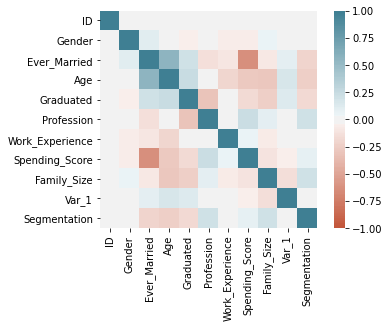

In [20]:
# get complete heatmap of all corelation coefficients
import seaborn as sns
corr = df_train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

In [21]:
oheGender = pd.get_dummies(df_train["Gender"], prefix='Gender')
df_train = pd.concat([df_train, oheGender], axis=1)
df_train = df_train.drop("Gender" , axis=1)

# oheGender = pd.get_dummies(df_train["Ever_Married"], prefix='Ever_Married')
# df_train = pd.concat([df_train, oheGender], axis=1)
# df_train = df_train.drop("Ever_Married" , axis=1)

# oheGender = pd.get_dummies(df_train["Graduated"], prefix='Graduated')
# df_train = pd.concat([df_train, oheGender], axis=1)
# df_train = df_train.drop("Graduated" , axis=1)

# oheGender = pd.get_dummies(df_train["Profession"], prefix='Profession')
# df_train = pd.concat([df_train, oheGender], axis=1)
# df_train = df_train.drop("Profession" , axis=1)

df_train

,ID,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Gender_0,Gender_1
0,462809,0,22,0,5,1,2,4,3,3,0,1
1,466315,1,67,1,2,1,2,1,5,1,1,0
2,461735,1,67,1,7,0,1,2,5,1,0,1
3,461319,1,56,0,0,0,0,2,5,2,0,1
4,460156,0,32,1,5,1,2,3,5,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6660,463002,1,41,1,0,0,1,5,5,1,0,1
6661,464685,0,35,0,4,3,2,4,3,3,0,1
6662,465406,0,33,1,5,1,2,1,5,3,1,0
6663,467299,0,27,1,5,1,2,4,5,1,1,0


In [22]:
def train_model(X , Y):
    # classifier = LGBMClassifier()
    # param_grid = {"max_depth":[4,6,8,10,-1],
    #       "learning_rate":[0.001,0.005,0.01,0.05,0.1,0.3],
    #       "subsample":[0.5,0.6,0.7,0.8,0.9],
    #       "colsample_bytree":[0.5,0.6,0.7,0.8,0.9],
    #       "reg_alpha":[0,0.25,0.5,1,2],
    #       "reg_lambda":[0,0.25,0.5,1,2],
    #       "num_leaves":[7,15,31,63,127],
    #       "min_data_in_leaf":[1,3,5,7,10,25],
    #       "n_estimators":list(range(50,1001,100))}

    # model = RandomizedSearchCV(estimator = classifier,
    #                     param_distributions = param_grid,
    #                     cv = 5,
    #                     n_iter = 10,
    #                     verbose=1000
    #                     )

    classifier = XGBClassifier(n_jobs = -1)
    param_grid = {
        "n_estimators" : np.arange(100,1200,100),
        "max_depth" : np.arange(3,10)
    }

    model = RandomizedSearchCV(estimator = classifier,
                        param_distributions = param_grid,
                        cv = 5,
                        n_iter = 5,
                        verbose=1000
                        )
    
    # param_grid = {
    #     "n_neighbors" : np.arange(3,8),
    #     "weights" : ["uniform" , "distance"],
    #     "leaf_size" : np.arange(25,35)
    # }
    # classifier = KNeighborsClassifier()
    # model = RandomizedSearchCV(estimator = classifier,
    #                 param_distributions = param_grid,
    #                 cv = 5,
    #                 n_iter = 20,
    #                 verbose=1000
    #                 )

    model.fit(X,Y)

    return model



def prediction(model):
    submit = pd.read_csv("/content/test.csv")
    submit['Gender'] = submit['Gender'].replace(np.nan, "Male")
    submit['Ever_Married'] = submit['Ever_Married'].replace(np.nan, "Yes")
    submit['Graduated'] = submit['Graduated'].replace(np.nan, "Yes")
    submit['Profession'] = submit['Profession'].replace(np.nan, "Artist")
    submit['Work_Experience'] = submit['Work_Experience'].replace(np.nan, 0)
    submit['Spending_Score'] = submit['Spending_Score'].replace(np.nan, "Low")
    submit['Family_Size'] = submit['Family_Size'].replace(np.nan, 2)
    submit['Var_1'] = submit['Var_1'].replace(np.nan, "Cat_6")


    submit["Work_Experience"] = submit["Work_Experience"].astype("int")
    submit["Family_Size"] = submit["Family_Size"].astype("int")
    print(submit["Profession"].value_counts())

    submit["Gender"] = le.fit_transform(submit["Gender"])
    submit["Ever_Married"] = le.fit_transform(submit["Ever_Married"])
    submit["Graduated"] = le.fit_transform(submit["Graduated"])
    submit["Profession"] = le.fit_transform(submit["Profession"])
    submit["Spending_Score"] = le.fit_transform(submit["Spending_Score"])
    submit["Var_1"] = le.fit_transform(submit["Var_1"])
    print(submit["Profession"].value_counts())


    oheGender = pd.get_dummies(submit["Gender"], prefix='Gender')
    submit = pd.concat([submit, oheGender], axis=1)
    submit = submit.drop("Gender" , axis=1)

    # oheGender = pd.get_dummies(submit["Ever_Married"], prefix='Ever_Married')
    # submit = pd.concat([submit, oheGender], axis=1)
    # submit = submit.drop("Ever_Married" , axis=1)

    # oheGender = pd.get_dummies(submit["Graduated"], prefix='Graduated')
    # submit = pd.concat([submit, oheGender], axis=1)
    # submit = submit.drop("Graduated" , axis=1)

    # oheGender = pd.get_dummies(submit["Profession"], prefix='Profession')
    # submit = pd.concat([submit, oheGender], axis=1)
    # submit = submit.drop("Profession" , axis=1)




    drop = copy.deepcopy(col_to_drop)
    drop.remove("Segmentation")
    X = submit.drop(drop , axis=1)




    print(X.info())

    col1 = submit["ID"].values
    print(X.shape)



    # arr_to_stan = np.array(submit["Estimated_Insects_Count"]).reshape((-1,1))
    # scaler = MinMaxScaler(feature_range=(0, 1)) 
    # X["Estimated_Insects_Count"] = scaler.fit_transform(arr_to_stan) 

    # arr_to_stan = np.array(submit["Number_Doses_Week"]).reshape((-1,1))
    # scaler = MinMaxScaler(feature_range=(0, 1)) 
    # X["Number_Doses_Week"] = scaler.fit_transform(arr_to_stan) 

    # arr_to_stan = np.array(submit["Number_Weeks_Used"]).reshape((-1,1))
    # scaler = MinMaxScaler(feature_range=(0, 1)) 
    # X["Number_Weeks_Used"] = scaler.fit_transform(arr_to_stan) 

    # arr_to_stan = np.array(submit["Number_Weeks_Quit"]).reshape((-1,1))
    # scaler = MinMaxScaler(feature_range=(0, 1)) 
    # X["Number_Weeks_Quit"] = scaler.fit_transform(arr_to_stan) 

    # np.set_printoptions(precision=3)

    col2 = model.predict(X)
    col2 = list(map(mapping_dict.get, col2))

    dict = {'ID': col1, 'Segmentation': col2} 
    df_fin = pd.DataFrame(dict) 

    filename = "ans.csv"
    df_fin.to_csv(filename , index=False)
    from google.colab import files
    files.download(filename)


In [23]:
# ID	Gender	Ever_Married	Age	Graduated	Profession	Work_Experience	 Spending_Score	Family_Size	  Var_1	Segmentation
col_to_drop = ["Segmentation" , "Ever_Married" , "ID"   , "Var_1"  ,"Profession" ,"Family_Size" ]
X = df_train.drop(col_to_drop , axis=1)
Y = df_train["Segmentation"]
print(X.shape, Y.shape)

model = train_model(X , Y)

(6665, 6) (6665,)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] n_estimators=200, max_depth=5 ...................................
[CV] ....... n_estimators=200, max_depth=5, score=0.490, total=   1.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[CV] n_estimators=200, max_depth=5 ...................................
[CV] ....... n_estimators=200, max_depth=5, score=0.450, total=   1.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[CV] n_estimators=200, max_depth=5 ...................................
[CV] ....... n_estimators=200, max_depth=5, score=0.479, total=   1.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[CV] n_estimators=200, max_depth=5 ...................................
[CV] ....... n_estimators=200, max_depth=5, score=0.495, total=   1.1s
[Parallel(n_jobs=1)]: Done   4 ou

In [24]:
print(model.best_score_)
print(model.best_estimator_.get_params())
print(model.score(X,Y))
prediction(model)


# gives 56% accuracy
# there was data leak with IDS of train and test dataset.
# If you use data leak, easily, 93% can be achieved.


0.48102025506376594
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': -1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
0.5653413353338335
Artist           840
Healthcare       418
Entertainment    301
Doctor           242
Engineer         236
Lawyer           221
Executive        176
Marketing        111
Homemaker         82
Name: Profession, dtype: int64
0    840
5    418
3    301
1    242
2    236
7    221
4    176
8    111
6     82
Name: Profession, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           -------------- 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>